In [51]:
import os, sys, scipy
import math, glob
import numpy as np
import subprocess
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.optimize import fsolve


In [7]:
def get_pressure_abacus(filename, start, end, nskip=10, debug=False):
    """
        This function reads running_md.log (default filename)
        from molecular dynamics calculation.

        It forms a numpy array of size: niteration rows x 2 columns
        data[:,0] : the first column is iteration number
        data[:,1] : the second column is the total pressure (ionic + electronic)
    """
    keyword="MD PRESSURE"
    relevant_lines=[]

    # dtype = np.dtype([('id', np.int32), ('value', np.float64)])

    with open(filename, 'r') as file:
        for line in file:
            if keyword in line:
                relevant_lines.append(line)

    nlines=len(relevant_lines)
    data = np.zeros((nlines,2))

    # data = np.zeros((nlines,2), dtype=dtype )
    for i in range(nlines):
        data[i, 0] = int(i)
        if debug:
            print(relevant_lines[i].split())
        data[i, 1] = float(relevant_lines[i].split()[4])

    # after the data is extracted, get the average and standard deviation
    avg = np.mean(data[start:end:nskip, 1], axis=0)
    std = np.std(data[start:end:nskip, 1], axis=0)
    return float(avg), float(std)

In [8]:
def get_pressure_lammps(filename, start=0, end=-1, nskip=10, debug=False):
# def get_pressure_lammps(filename, nskip=10, debug=False):
    """
        This function reads running_md.log (default filename)
        from molecular dynamics calculation.

        It forms a numpy array of size: niteration rows x 2 columns
        data[:,0] : the first column is iteration number
        data[:,1] : the second column is the total pressure (ionic + electronic)
    """
    with open(filename) as f:
        lines = f.readlines()

    step_indices = [i for i, line in enumerate(lines) if line.strip().startswith("Step")]
    loop_indices = [i for i, line in enumerate(lines) if "Loop time" in line]

    if len(step_indices) < 2 or len(loop_indices) < 2:
        print("Not enough 'Step' or 'Loop time' entries found.")
        return

    start_idx = step_indices[1] +1
    # Find the first loop time after second Step
    end_idx = next(i for i in loop_indices if i > start_idx)

    # for line in lines[start_idx:end_idx + 1]:
    #     print(line, end='')
        

    nlines=end_idx - start_idx - 2
    data = np.zeros((nlines,2))
    if debug:
        print("nlines = ", nlines)
    # # data = np.zeros((nlines,2), dtype=dtype )
    for i in range(nlines):
        data[i, 0] = int(i)
        # if debug:
        #     # print(relevant_lines[i].split())
        #     print("number of lines: ",  int(nlines))
        data[i, 1] = float(lines[i+start_idx].split()[2])

    # after the data is extracted, get the average and standard deviation
    avg = np.mean(data[start:end, 1], axis=0)
    std = np.std(data[start:end:, 1], axis=0)
    return float(avg), float(std)

In [9]:
# get_pressure_lammps("../RUN/0.4-5000/log.lammps", start=50)

In [10]:
# RHOLIST=[0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4]
# TLIST = [5000, 5500, 6000, 6500, 7000, 7500, 8000]


# outfile=open("eos.csv", "w")
# outfile.write("T(K),rho(g/cc),P(kbar),Perr(kbar)\n")

# for T in TLIST:
#     for rho in RHOLIST:
#         filename= os.path.join("../RUN/", str(rho)+'-'+str(T), 'log.lammps')
#         avg, std = get_pressure_lammps(filename, start=90)
#         # print("%d,%.2f,%.3f,%.3f" % (T,  rho, avg, std) )
#         outfile.write("%d,%.2f,%.3f,%.3f\n" % (T,  rho, avg/1e3, std/1e3))
# outfile.close()


In [11]:
df = pd.read_csv("eos.csv")
df

# df[df['T(K)'] == 6000]

,T(K),rho(g/cc),P(kbar),Perr(kbar)
0,5000,0.4,0.222,0.275
1,5000,0.5,0.203,0.374
2,5000,0.6,-0.076,0.439
3,5000,0.7,-0.099,0.511
4,5000,0.8,-0.214,0.610
...,...,...,...,...
72,8000,1.0,8.575,0.823
73,8000,1.1,11.013,0.934
74,8000,1.2,14.350,1.034
75,8000,1.3,18.863,1.075


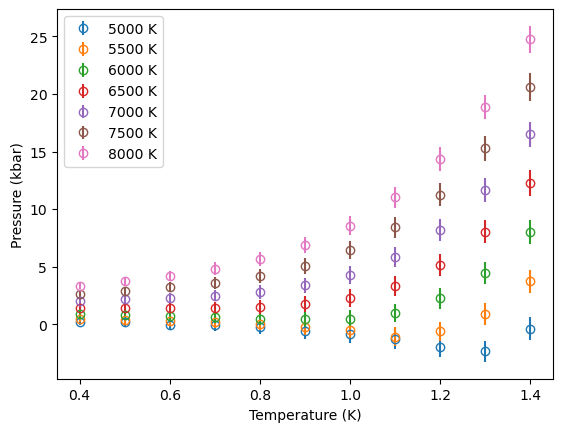

In [12]:

plt.xlabel("Temperature (K)")
plt.ylabel("Pressure (kbar)")

# plt.plot(df[df['T(K)'] == 5000]['rho(g/cc)'], df[df['T(K)'] == 5000]['P(kbar)'], marker="o", label="5000 K" )
# plt.plot(df[df['T(K)'] == 6000]['rho(g/cc)'], df[df['T(K)'] == 6000]['P(kbar)'], marker="o", label="6000 K" )
# plt.plot(df[df['T(K)'] == 7000]['rho(g/cc)'], df[df['T(K)'] == 7000]['P(kbar)'], marker="o", label="7000 K" )
# plt.plot(df[df['T(K)'] == 8000]['rho(g/cc)'], df[df['T(K)'] == 8000]['P(kbar)'], marker="o", label="8000 K" )
# plt.plot(df[df['T(K)'] == 9000]['rho(g/cc)'], df[df['T(K)'] == 9000]['P(kbar)'], marker="o", label="9000 K" )
# plt.plot(df[df['T(K)'] == 6000]['rho(g/cc)'], df[df['T(K)'] == 6000]['P(kbar)'], marker="o", )

# plt.errorbar(df[df['T(K)'] == 4000]['rho(g/cc)'], df[df['T(K)'] == 4000]['P(kbar)'], 
#              yerr=df[df['T(K)'] == 4000]['Perr(kbar)'], fmt='o', fillstyle='none' , label="4000 K")
plt.errorbar(df[df['T(K)'] == 5000]['rho(g/cc)'], df[df['T(K)'] == 5000]['P(kbar)'],
             yerr=df[df['T(K)'] == 5000]['Perr(kbar)'], fmt='o', fillstyle='none', label="5000 K" )

plt.errorbar(df[df['T(K)'] == 5500]['rho(g/cc)'], df[df['T(K)'] == 5500]['P(kbar)'],
             yerr=df[df['T(K)'] == 5500]['Perr(kbar)'], fmt='o', fillstyle='none', label="5500 K" )

plt.errorbar(df[df['T(K)'] == 6000]['rho(g/cc)'], df[df['T(K)'] == 6000]['P(kbar)'], 
             yerr=df[df['T(K)'] == 6000]['Perr(kbar)'], fmt='o', fillstyle='none', label="6000 K")

plt.errorbar(df[df['T(K)'] == 6500]['rho(g/cc)'], df[df['T(K)'] == 6500]['P(kbar)'], 
             yerr=df[df['T(K)'] == 6500]['Perr(kbar)'], fmt='o', fillstyle='none', label="6500 K")
plt.errorbar(df[df['T(K)'] == 7000]['rho(g/cc)'], df[df['T(K)'] == 7000]['P(kbar)'], 
             yerr=df[df['T(K)'] == 7000]['Perr(kbar)'], fmt='o', fillstyle='none', label="7000 K" )

plt.errorbar(df[df['T(K)'] == 7500]['rho(g/cc)'], df[df['T(K)'] == 7500]['P(kbar)'], 
             yerr=df[df['T(K)'] == 7500]['Perr(kbar)'], fmt='o', fillstyle='none', label="7500 K" )

plt.errorbar(df[df['T(K)'] == 8000]['rho(g/cc)'], df[df['T(K)'] == 8000]['P(kbar)'], 
             yerr=df[df['T(K)'] == 8000]['Perr(kbar)'], fmt='o', fillstyle='none', label="8000 K" )
# plt.errorbar(df[df['T(K)'] == 9000]['rho(g/cc)'], df[df['T(K)'] == 9000]['P(kbar)'], yerr=df[df['T(K)'] == 9000]['Perr(kbar)'], fmt='o', fillstyle='none' )
plt.legend()

plt.savefig("EOS_errorbar.png", dpi=200)

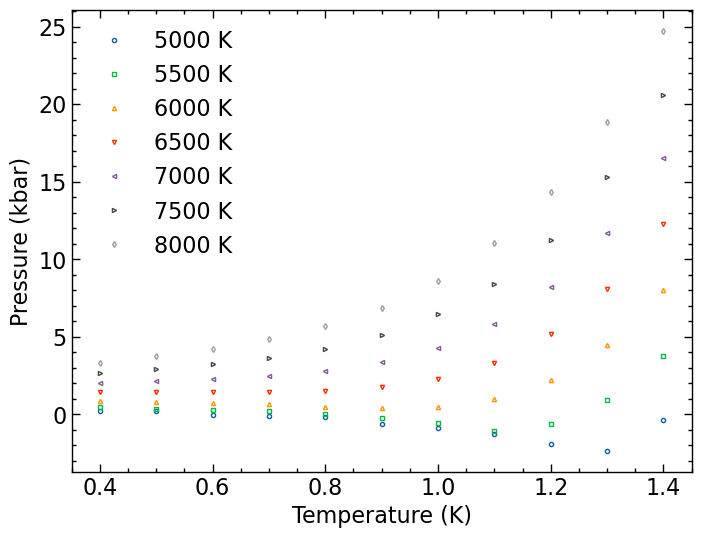

In [13]:
import scienceplots

with plt.style.context(['science', 'nature','vibrant', "notebook", 'scatter']):

    plt.xlabel("Temperature (K)")
    plt.ylabel("Pressure (kbar)")
    
    
    # plt.errorbar(df[df['T(K)'] == 4000]['rho(g/cc)'], df[df['T(K)'] == 4000]['P(kbar)'], 
    #              yerr=df[df['T(K)'] == 4000]['Perr(kbar)'], fmt='o', fillstyle='none' , label="4000 K")
    plt.plot(df[df['T(K)'] == 5000]['rho(g/cc)'], df[df['T(K)'] == 5000]['P(kbar)'],
                  fillstyle='none', label="5000 K" )
    
    plt.plot(df[df['T(K)'] == 5500]['rho(g/cc)'], df[df['T(K)'] == 5500]['P(kbar)'],
                 fillstyle='none', label="5500 K" )
    
    plt.plot(df[df['T(K)'] == 6000]['rho(g/cc)'], df[df['T(K)'] == 6000]['P(kbar)'], 
                 fillstyle='none', label="6000 K")
    
    plt.plot(df[df['T(K)'] == 6500]['rho(g/cc)'], df[df['T(K)'] == 6500]['P(kbar)'], 
                 fillstyle='none', label="6500 K")
    plt.plot(df[df['T(K)'] == 7000]['rho(g/cc)'], df[df['T(K)'] == 7000]['P(kbar)'], 
                  fillstyle='none', label="7000 K" )

    plt.plot(df[df['T(K)'] == 7500]['rho(g/cc)'], df[df['T(K)'] == 7500]['P(kbar)'], 
                 fillstyle='none', label="7500 K" )
    
    plt.plot(df[df['T(K)'] == 8000]['rho(g/cc)'], df[df['T(K)'] == 8000]['P(kbar)'], 
                  fillstyle='none',label="8000 K" )
    # plt.plot(df[df['T(K)'] == 9000]['rho(g/cc)'], df[df['T(K)'] == 9000]['P(kbar)'], yerr=df[df['T(K)'] == 9000]['Perr(kbar)'], fillstyle='none' )
    plt.legend()

plt.savefig("EOS_pretty.png", dpi=200)

In [53]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.optimize import curve_fit

# # --- Load data ---
# df = pd.read_csv("eos.csv")

# # Filter: T > 5500 K
# df = df[df["T(K)"] > 5500]

# T = df["T(K)"].values
# rho = df["rho(g/cc)"].values
# P = df["P(kbar)"].values
# Perr = df["Perr(kbar)"].values

# # --- Define EOS function with quadratic T terms ---
# def eos_model(vars, a0, a1, a2, b0, b1, b2, c0, c1, c2):
#     T, rho = vars
#     return ((a0 + a1*T + a2*T**2) * rho +
#             (b0 + b1*T + b2*T**2) * rho**2 +
#             (c0 + c1*T + c2*T**2) * rho**3)

# # --- Fit parameters ---
# p0 = [1, 0, 0, 1, 0, 0, 1, 0, 0]  # initial guess
# popt, pcov = curve_fit(
#     eos_model, (T, rho), P,
#     sigma=Perr, absolute_sigma=True,
#     p0=p0
# )

# # --- Extract results ---
# perr = np.sqrt(np.diag(pcov))
# params = ["a0","a1","a2","b0","b1","b2","c0","c1","c2"]

# print("Fitted EOS parameters (quadratic in T, T > 5500 K):")
# for name, val, err in zip(params, popt, perr):
#     print(f"{name:>3} = {val:12.6f} ± {err:.6f}")

# # --- Plot EOS vs Data ---
# unique_T = np.unique(T)

# plt.figure(figsize=(10,7))

# for Tplot in unique_T:
#     mask = (T == Tplot)
#     rho_vals = rho[mask]
#     P_vals = P[mask]
#     Perr_vals = Perr[mask]
    
#     # Sort for plotting
#     order = np.argsort(rho_vals)
#     rho_vals = rho_vals[order]
#     P_vals = P_vals[order]
#     Perr_vals = Perr_vals[order]
    
#     # Scatter data
#     plt.errorbar(rho_vals, P_vals, yerr=Perr_vals, fmt='o', ms=4, label=f"Data T={Tplot} K")
    
#     # Fit curve
#     rho_fit = np.linspace(rho_vals.min(), rho_vals.max(), 200)
#     P_fit = eos_model((np.full_like(rho_fit, Tplot), rho_fit), *popt)
#     plt.plot(rho_fit, P_fit, '-', lw=1)

# plt.xlabel(r"Density $\rho$ (g/cc)")
# plt.ylabel(r"Pressure $P$ (kbar)")
# plt.title("EOS Fit with Quadratic T terms (T > 5500 K)")
# plt.legend(fontsize=8, ncol=2, frameon=False)
# # plt.tight_layout()
# plt.show()


In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# -------------------------
# Load & filter data
# -------------------------
df = pd.read_csv("eos.csv")
df = df[df["T(K)"] > 5500].copy()
if df.empty:
    raise RuntimeError("No data with T > 5500 K found in eos.csv")

T = df["T(K)"].values.astype(float)
rho = df["rho(g/cc)"].values.astype(float)
P = df["P(kbar)"].values.astype(float)
Perr = df["Perr(kbar)"].values.astype(float)

# -------------------------
# Define model: linear in T, up to rho^4
# -------------------------
def eos_model(vars, a0, a1, b0, b1, c0, c1, d0, d1):
    T, rho = vars
    term1 = (a0 + a1*T) * rho
    term2 = (b0 + b1*T) * rho**2
    term3 = (c0 + c1*T) * rho**3
    term4 = (d0 + d1*T) * rho**4
    return term1 + term2 + term3 + term4

# First and second derivatives w.r.t. rho
def dP_drho(T, rho, popt):
    a0, a1, b0, b1, c0, c1, d0, d1 = popt
    return (a0 + a1*T) + 2*(b0 + b1*T)*rho + 3*(c0 + c1*T)*rho**2 + 4*(d0 + d1*T)*rho**3

def d2P_drho2(T, rho, popt):
    a0, a1, b0, b1, c0, c1, d0, d1 = popt
    return 2*(b0 + b1*T) + 6*(c0 + c1*T)*rho + 12*(d0 + d1*T)*rho**2

# System of equations for critical point
def crit_eqs(x, popt):
    T, rho = x
    eq1 = dP_drho(T, rho, popt)
    eq2 = d2P_drho2(T, rho, popt)
    return [eq1, eq2]


# Tc, rhoc = fsolve(crit_eqs, [T_guess, rho_guess], args=(popt))

# Pc = eos_model((Tc, rhoc), *popt)

# print(f"\nCritical point (analytical, from fit):")
# print(f"Tc = {Tc:.2f} K")
# print(f"rho_c = {rhoc:.4f} g/cc")
# print(f"P_c = {Pc:.4f} kbar")


# -------------------------
# Initial guess and fit
# -------------------------
# modest guesses: a0 ~ 1, others zero
p0 = np.array([1.0, 0.0,   0.0, 0.0,   0.0, 0.0,   0.0, 0.0])

# curve_fit with weights from Perr (absolute_sigma=True interprets sigma as true errors)
popt, pcov = curve_fit(
    eos_model,
    (T, rho),
    P,
    sigma=Perr,
    absolute_sigma=True,
    p0=p0,
    maxfev=20000
)

# Initial guess (adjust as needed)
T_guess = np.mean(df["T(K)"])
rho_guess = np.mean(df["rho(g/cc)"])
Tc, rhoc = fsolve(crit_eqs, [T_guess, rho_guess], args=(popt))

Pc = eos_model((Tc, rhoc), *popt)

print(f"\nCritical point (analytical, from fit):")
print(f"Tc = {Tc:.2f} K")
print(f"rho_c = {rhoc:.4f} g/cc")
print(f"P_c = {Pc:.4f} kbar")

# -------------------------
# Report parameters + uncertainties
# -------------------------
names = ["a0","a1","b0","b1","c0","c1","d0","d1"]
perr = np.sqrt(np.abs(np.diag(pcov)))  # abs for numerical safety

print("Fitted parameters (linear in T, up to rho^4)  [T>5500K]:")
for n, val, err in zip(names, popt, perr):
    print(f"{n:>3} = {val:12.6e} ± {err:12.6e}")

# goodness-of-fit
N = len(P)
p = len(popt)
resid = P - eos_model((T, rho), *popt)
rss = np.sum(resid**2)
sigma2_hat = rss / (N - p) if N > p else np.nan
print(f"\nN = {N}, parameters = {p}, RSS = {rss:.6e}, estimated residual var = {sigma2_hat:.6e}")




Critical point (analytical, from fit):
Tc = 6539.36 K
rho_c = 0.6370 g/cc
P_c = 1.6075 kbar
Fitted parameters (linear in T, up to rho^4)  [T>5500K]:
 a0 = -3.688016e+01 ± 2.471628e+01
 a1 = 6.279737e-03 ± 3.532013e-03
 b0 = 9.286414e+01 ± 9.544858e+01
 b1 = -1.358005e-02 ± 1.364680e-02
 c0 = -1.227647e+02 ± 1.134721e+02
 c1 = 1.589653e-02 ± 1.623157e-02
 d0 = 4.275704e+01 ± 4.213722e+01
 d1 = -4.535375e-03 ± 6.029996e-03

N = 55, parameters = 8, RSS = 4.746672e-01, estimated residual var = 1.009930e-02


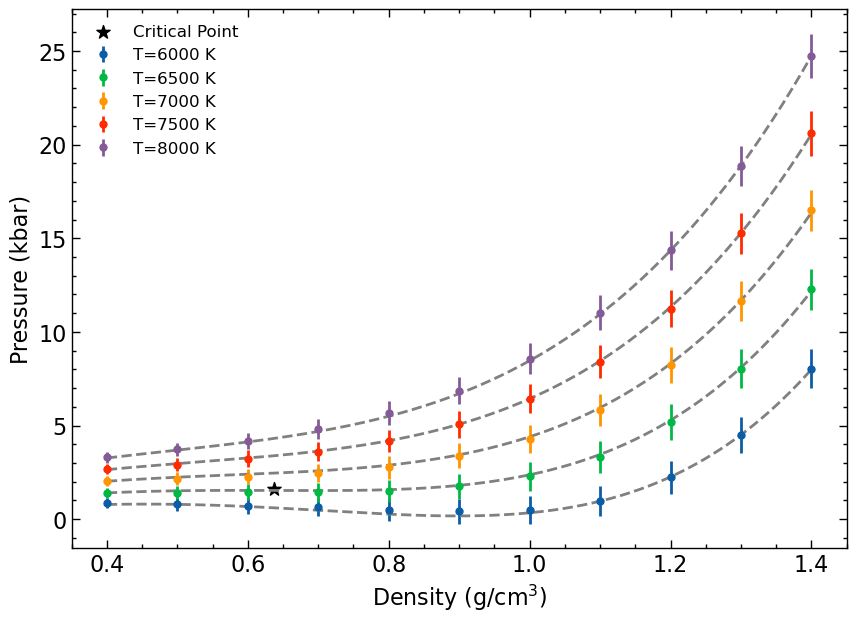

In [82]:


# with plt.style.context(['science', 'nature','vibrant', "notebook", 'scatter']):
with plt.style.context(['science', 'nature', "notebook"]):
    # -------------------------
    # Plot every isotherm
    # -------------------------
    unique_T = np.unique(T)
    plt.figure(figsize=(10,7))
    
    for Tplot in unique_T:
        mask = (T == Tplot)
        rho_vals = rho[mask]
        P_vals = P[mask]
        Perr_vals = Perr[mask]
        if rho_vals.size == 0:
            continue
    
        # sort for plotting
        idx = np.argsort(rho_vals)
        rho_vals = rho_vals[idx]
        P_vals = P_vals[idx]
        Perr_vals = Perr_vals[idx]
    
        # data points with error bars
        plt.errorbar(rho_vals, P_vals, yerr=Perr_vals, fmt='o', ms=5, label=f"T={int(Tplot)} K")
    
        # fitted curve for that T
        rho_fit = np.linspace(rho_vals.min(), rho_vals.max(), 300)
        Tvec = np.full_like(rho_fit, Tplot, dtype=float)
        P_fit = eos_model((Tvec, rho_fit), *popt)
        plt.plot(rho_fit, P_fit, '--', color='grey')

        # Mark the critical point
    plt.scatter(rhoc, Pc, color='black', marker='*', s=100, label='Critical Point')
    # plt.annotate(f"Critical\nT={Tc:.1f}K\nρ={rhoc:.3f}\nP={Pc:.2f}",
    #              (rhoc, Pc), textcoords="offset points", xytext=(30,-30), ha='center', color='red')

    plt.xlabel(r"Density (g/cm$^3$)")
    plt.ylabel(r"Pressure (kbar)")
    # plt.title("EOS fit")
    plt.legend(fontsize=12, ncol=1, frameon=False)
    # plt.tight_layout()
plt.savefig("eos_4th_order.png", dpi=300)
plt.show()
